<a href="https://colab.research.google.com/github/okana2ki/ML/blob/main/Chap2_MNIST_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://weblabo.oscasierra.net/python/keras-mnist-sample.html

# ★このノートブックは、「[第2章_MNIST.ipynb](https://colab.research.google.com/drive/1W1D7DOV9UymHLwgPR1HF3KfBtib5PkH0?usp=sharing)」 を岡が適宜加筆修正したものです。★

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.optimizers import RMSprop
# MNISTデータを読込む
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
print(X_train.dtype)

uint8


In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
print(y_train.dtype)

uint8


In [ ]:
print(f"X_train(学習用の画像データのサイズ) : {X_train.shape}")
print(f"y_train(学習データの正解ラベルのサイズ) : {y_train.shape}")
print(f"X_test(検証用の画像データのサイズ) : {X_test.shape}")
print(f"y_test(検証データの正解ラベルのサイズ) : {y_test.shape}")

X_train(学習用の画像データのサイズ) : (60000, 28, 28)
y_train(学習データの正解ラベルのサイズ) : (60000,)
X_test(検証用の画像データのサイズ) : (10000, 28, 28)
y_test(検証データの正解ラベルのサイズ) : (10000,)


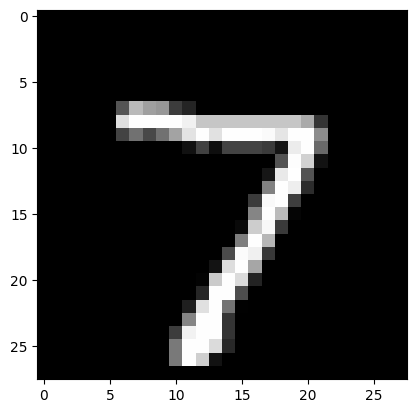

In [ ]:
import matplotlib.pyplot as plt
sample = 0
image = X_test[sample]

# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

さて、この28行28列のデータですが、下記のニューラルネットワークの入力形式に合わせるため、まず1行に並べてしまいます（あるいは1列にならべてしまいます）。

In [ ]:
X_train  = X_train.reshape(60000, 784)
X_test   = X_test.reshape(10000, 784)
print("X_train.shape(学習用の画像データ) : ", X_train.shape)
print("y_train_shape(学習用の正解データ) : ", y_train.shape)
print("X_test.shape(検証用の画像データ) : ", X_test.shape)
print("y_test.shape(検証用の正解データ) : ", y_test.shape)

X_train.shape(学習用の画像データ) :  (60000, 784)
y_train_shape(学習用の正解データ) :  (60000,)
X_test.shape(検証用の画像データ) :  (10000, 784)
y_test.shape(検証用の正解データ) :  (10000,)


MNIST のピクセル情報を計算の都合上、0-1.0 の範囲の数値にする。
データを「32 ビット浮動小数点数型」float32 に変換してから255 で割る。
uint8 型を255で割ると整数除算となり、0か1の値しか得られない。

In [ ]:
# 最初にデータを小数点を含む値(float) 型に変換
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# 0-255 のデータを 0-1 の範囲に変換
X_train /= 255
X_test  /= 255

次に正解ラベルをワンホットエンコーディングします。例えば「5」という数字であれば [0,0,0,0,0,1,0,0,0,0] と、6番目（0起算なので）だけ1で、残りは0のリストに変換します。カテゴリ化と言い換えることもできます。kerasの機能を使います。

In [ ]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test  = keras.utils.to_categorical(y_test, 10)

In [ ]:
print("y_train.shape(学習用の正解データ) : ", y_train.shape)
print("y_test.shape(検証用の正解データ) : ", y_test.shape)

y_train.shape(学習用の正解データ) :  (60000, 10)
y_test.shape(検証用の正解データ) :  (10000, 10)


In [ ]:
print(y_train.dtype)

float64


↑ニューラルネットワークの学習時の精度を高くするために、float64を使用

さて、これでデータの準備が終わりました。
次に、学習データをニューラルネットワークに与え、その結果を使ってテストデータの精度を検証します。
ニューラルネットワークは、学習データ（画像）とそのラベル（書かれている数字）の対応を学習します。続いて、その学習結果を使って、学習には使っていないデータ、つまりテストデータの画像から、書かれている数字を認識します。テストデータには正解のラベルがあるので、ニューラルネットワークの認識結果（精度）を評価できるわけです。

学習では、ニューラルネットワークは与えられた画像からラベルを推定し、それが正解と一致してるかどうかを調べ、正解との誤差が小さくなるよう学習することを繰り返します。
これは、誤差逆伝播法として知られるアルゴリズムです。kerasライブラリは、これを簡潔に記述できます。

In [ ]:
model = Sequential()
model.add(InputLayer(shape=(784,)))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

初めに学習内容を保存するモデルを用意します。`Sequential` は、ここでは入力から出力への処理が流れることを表していると考えてください。
次にモデルに入力を加えます。入力データの次元（28行28列を平たん化した784の数値であること）を指定します。
3行目は、入力された画像のラベルが10種類あることを表しています。softmaxという指定は、画像ごとに各ラベル（数字）の推定確率を求めるという指示です。
最後の4行目で学習の方法を指定しています。学習は入力と出力が一致するよう、繰り返し調整していきますが、その方法を指定しています。


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7541 - loss: 0.9679 - val_accuracy: 0.9099 - val_loss: 0.3428
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9050 - loss: 0.3458 - val_accuracy: 0.9167 - val_loss: 0.3007
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9135 - loss: 0.3100 - val_accuracy: 0.9191 - val_loss: 0.2875
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9185 - loss: 0.2904 - val_accuracy: 0.9215 - val_loss: 0.2808
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9213 - loss: 0.2840 - val_accuracy: 0.9244 - val_loss: 0.2784
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9238 - loss: 0.2771 - val_accuracy: 0.9251 - val_loss: 0.2734
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9245 - loss: 0.2748 - val_accuracy: 0.9251 - val_loss: 0.2720
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9240 - loss: 0.2746 - val_accuracy: 0.

学習経過の可視化

　ここまでで、ニューラルネットワークモデルの作成と評価は完了です。 さて、気になるのは「学習して賢くなったのか？」ということではないでしょうか。 学習を繰り返すたびに賢くなっていることが、視覚的にわかるととても安心できます。

　上で実行した model.fit() の戻り値 history から、学習経過を可視化することができます。 history には学習状況が格納されており、次のようなものを含んでいます。

　loss : loss は日本語で損失と訳されます。 ここでの loss は、学習用データに対する「損失」の値です。 値の意味としては、小さい数字ほど正しい結果を出せるように学習できたことを表し、逆に値が大きい場合は正しい結果を出せていないことを表します。

　 val_loss : val_loss は、検証用データを与えて試した際に、どれだけ正しい結果を出せたのかということを表します。 値が小さいほど正しい結果を出せ、値が大きいほど正しい結果をだせていないことを表します。

　総じて、loss は学習状況を示す指標となる数字だと覚えておけばよいでしょう。

　この loss と val_loss の値を二次元グラフにして表示してみます。 縦軸には loss の値を、横軸には学習回数(ここでは20回学習させている)を割り当てて、学習ごとの loss と val_loss をグラフにしてみます。


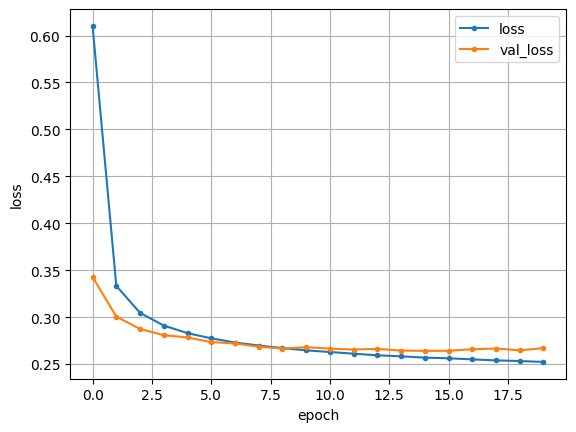

In [ ]:
loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()



グラフからは、学習が進むにつれて loss の値が徐々に下がり、学習が順調に行われているようにみえます。
ただ  val_loss のほうは、後半は値が下がらなくなっています。

評価

結局、テストデータに対してどれくらいの精度の予測ができたのかを確認してみましょう。出来上がったニューラルネットワークに検証用データ (x_test と y_test )を与えて、正解率を求めて評価します。

正解率(accuracy) とは、今回の場合であれば「画像を正しく認識できる割合」を表しています。

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print(f'テストデータ：loss: {score[0]}')
print(f'テストデータ：Test accuracy: {score[1]}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9168 - loss: 0.3010
テストデータ：loss: 0.2670697569847107
テストデータ：Test accuracy: 0.927299976348877


## ニューラルネットワークの改良を試みる

改善策
1. 隠れ層の追加: 1つ以上の隠れ層を追加することで、モデルの表現能力を向上させることができます。隠れ層には、ReLUなどの活性化関数を使用することが一般的です。
2. Dropoutの追加: 隠れ層にDropoutを追加することで、過学習を防ぎ、モデルの汎化性能を向上させることができます。
3. 隠れ層のノード数: 隠れ層のノード数を調整することで、モデルの性能を最適化することができます。
4. 最適化アルゴリズム: 他の最適化アルゴリズム（例：Adam）を試すことで、より効率的に学習を進めることができる場合があります。

In [ ]:
model = Sequential()
model.add(InputLayer(shape=(784,)))
model.add(Dense(512, activation='relu'))  # 隠れ層を追加
model.add(Dropout(0.2))  # Dropoutを追加
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # 最適化アルゴリズムを変更

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8637 - loss: 0.4860 - val_accuracy: 0.9604 - val_loss: 0.1356
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9614 - loss: 0.1329 - val_accuracy: 0.9712 - val_loss: 0.0942
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9747 - loss: 0.0867 - val_accuracy: 0.9748 - val_loss: 0.0815
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9808 - loss: 0.0636 - val_accuracy: 0.9771 - val_loss: 0.0714
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9862 - loss: 0.0477 - val_accuracy: 0.9773 - val_loss: 0.0671
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9876 - loss: 0.0405 - val_accuracy: 0.9813 - val_loss: 0.0633
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9898 - loss: 0.0331 - val_accuracy: 0.9817 - val_loss: 0.0569
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9924 - loss: 0.0269 - val_accu

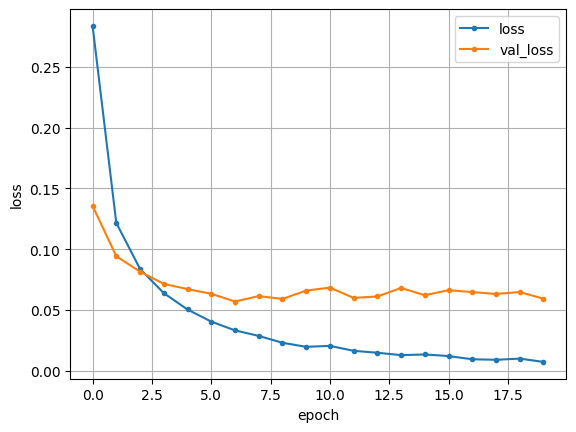

In [ ]:
loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print(f'テストデータ：loss: {score[0]}')
print(f'テストデータ：Test accuracy: {score[1]}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9803 - loss: 0.0745
テストデータ：loss: 0.05922270566225052
テストデータ：Test accuracy: 0.984000027179718


## 以下は未確認（岡）

In [ ]:

# MNISTデータを加工する
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
# モデルの構築
model = Sequential()
model.add(InputLayer(input_shape=(784,)))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# 学習
epochs = 20
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
# 検証
score = model.evaluate(x_test, y_test, verbose=1)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/20
469/469 [==============================] - 6s 11ms/step - loss: 0.6139 - accuracy: 0.8440 - val_loss: 0.3436 - val_accuracy: 0.9081
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3340 - accuracy: 0.9066 - val_loss: 0.3024 - val_accuracy: 0.9153
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3047 - accuracy: 0.9144 - val_loss: 0.2895 - val_accuracy: 0.9188
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2912 - accuracy: 0.9186 - val_loss: 0.2811 - val_accuracy: 0.9201
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.2832 - accuracy: 0.9212 - val_loss: 0.2747 - val_accuracy: 0.9237
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.2771 - accuracy: 0.9227 - val_loss: 0.2733 - val_accuracy: 0.9242
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.2735 -

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

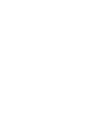

In [ ]:
import matplotlib.pyplot as plt
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.axis('off')
    plt.title(y_train[i])
    plt.imshow(x_train[i], cmap='gray')

plt.show()

NameError: name 'X_train' is not defined

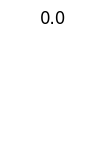

In [ ]:
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.axis('off')
    plt.title(y_train[i][0])  # Extract the first element of y_train[i]
    plt.imshow(X_train[i], cmap='gray')

plt.show()